In [1]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="Y1ye8fcMOvBPYovTMA20")
# project = rf.workspace("pascal-to-yolo-8yygq").project("inria-person-detection-dataset")
# version = project.version(1)
# dataset = version.download("voc")

In [2]:
#%pip install roboflow --user


In [3]:
#from roboflow import Roboflow
#rf = Roboflow(api_key="jFncRhXH91HwiZj24EbH")
#project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
#version = project.version(24)
#dataset = version.download("voc")


In [76]:
import cv2
import os
import xml.etree.ElementTree as ET
from pathlib import Path
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import pickle
import numpy as np

In [77]:
# Directory containing the images and XML files
input_dirs = [r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\Face-Detection-24\train',
              r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\Face-Detection-24\test']

# Crop size
crop_size = (64, 128)

# Directory to save the cropped positive images
positive_output_dir = r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\positive_cropped'
Path(positive_output_dir).mkdir(parents=True, exist_ok=True)

# Directory to save the cropped negative images
negative_output_dir = r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\negative_cropped'
Path(negative_output_dir).mkdir(parents=True, exist_ok=True)

# Iterate over each directory
for input_dir in input_dirs:
    # Iterate over each XML file in the directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".xml"):
            # Parse the XML file
            tree = ET.parse(os.path.join(input_dir, filename))
            root = tree.getroot()

            # Read the corresponding image
            img_filename = root.find('filename').text
            img = cv2.imread(os.path.join(input_dir, img_filename))

            # Create a mask of the same size as the image, filled with ones
            mask = np.ones(img.shape[:2], dtype=bool)

            # Iterate over each 'object' element in the XML file
            for i, obj in enumerate(root.iter('object')):
                # Get the bounding box coordinates
                bndbox = obj.find('bndbox')
                x1 = int(bndbox.find('xmin').text)
                y1 = int(bndbox.find('ymin').text)
                x2 = int(bndbox.find('xmax').text)
                y2 = int(bndbox.find('ymax').text)

                # Crop and resize the object from the image
                crop_img = img[y1:y2, x1:x2]
                crop_img = cv2.resize(crop_img, crop_size)

                # Save the cropped image based on the object type
                output_filename = f'{img_filename.split("_jpg")[0]}_crop_{i}.jpg'
                cv2.imwrite(os.path.join(positive_output_dir, output_filename), crop_img)

            # Generate negative samples
            for i in range(len(root.findall('object'))):
                while True:
                    # Choose a random location for the crop
                    y = np.random.randint(0, img.shape[0] - crop_size[1])
                    x = np.random.randint(0, img.shape[1] - crop_size[0])

                    # If the crop does not overlap with any object, save it and break the loop
                    if mask[y:y+crop_size[1], x:x+crop_size[0]].all():
                        crop_img = img[y:y+crop_size[1], x:x+crop_size[0]]
                        crop_img = cv2.resize(crop_img, crop_size)
                        cv2.imwrite(os.path.join(negative_output_dir, f'{img_filename.split("_jpg")[0]}_neg_crop_{i}.jpg'), crop_img)
                        break

In [78]:
IMAGE_SIZE = (128, 128)

In [79]:
def extract_features(images):
    features = []

    for image in images:
        # Resize the image to a consistent size
        image = cv2.resize(image, IMAGE_SIZE)

        # Compute HOG features
        hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")

        features.append(hog_features)

    return np.array(features)

In [80]:
# Assuming you have a directory containing positive and negative images
positive_dir = r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\positive_cropped'
negative_dir = r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\negative_cropped'

# Load positive images from directory
positive_images = []
for filename in os.listdir(positive_dir):
    image = cv2.imread(os.path.join(positive_dir, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    image = cv2.resize(image, IMAGE_SIZE)  # Resize to (64, 128)
    positive_images.append(image)

# Load negative images from directory
negative_images = []
for filename in os.listdir(negative_dir):
    image = cv2.imread(os.path.join(negative_dir, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    image = cv2.resize(image, IMAGE_SIZE)  # Resize to (64, 128)
    negative_images.append(image)

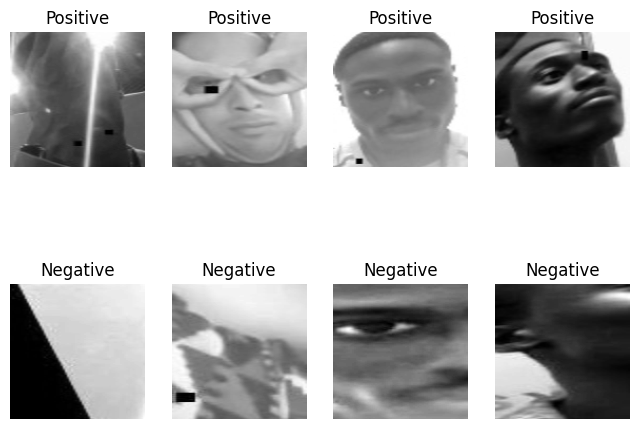

In [81]:
# visualize the positive and negative images
import matplotlib.pyplot as plt

random_indices = np.random.choice(len(positive_images), 4, replace=False).tolist()

positive_sample = [positive_images[i] for i in random_indices]
negative_sample = [negative_images[i] for i in random_indices]

fig, axes = plt.subplots(2, 4, figsize=(8, 6))
for i, image in enumerate(positive_sample):
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Positive')
for i, image in enumerate(negative_sample):
    axes[1, i].imshow(image, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Negative')
plt.show()

In [82]:
# Extract HOG features for positive and negative images
positive_features = extract_features(positive_images)
negative_features = extract_features(negative_images)

print(positive_features.shape, negative_features.shape)

(2551, 8100) (2551, 8100)


In [83]:
print(len(positive_features[0]))
print(len(negative_features[0]))
print(len(positive_features[1]))
print(len(negative_features[1]))

8100
8100
8100
8100


In [84]:
# Check that the feature vectors have the same length
assert positive_features.shape[1] == negative_features.shape[1]

In [85]:
# Stack the features and labels
X = np.vstack((positive_features, negative_features))
y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negative_features))))

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4081, 8100)
X_test shape: (1021, 8100)
y_train shape: (4081,)
y_test shape: (1021,)


In [87]:
print(len(X_train[0]))
len(X_train[1])

8100


8100

In [88]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution
param_dist = {
    'C': uniform(0.1, 1000),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': uniform(0.0001, 0.1)
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Perform the random search
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

# Train the model with the best parameters
model = SVC(**best_params, probability=True, random_state=42)
model.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [89]:
# train the linear SVM model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [90]:
# Initialize the linear SVM model
model = SVC(kernel='linear', probability=True, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [56]:
# Create SVM model with RBF kernel
model = SVC(kernel='rbf', gamma='scale', probability=True, random_state=42)
model.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

In [65]:
# Create SVM model with polynomial kernel
model = SVC(kernel='poly', degree=3, gamma='scale', coef0=10000)

# Train the model
model.fit(X_train, y_train)


SVC(coef0=10000, kernel='poly')

In [91]:
import pickle

# Save the trained model to a file
model_filename = "svm_new_model.pkl"

# Save the scaler to a file
scaler_filename = "scaler_new.pkl"

In [92]:
# Save the trained model and scaler
# with open('svm_classifier.pkl', 'wb') as f:
#     pickle.dump(model, f)

# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

In [93]:
# Load the trained model and scaler
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)


In [94]:
# Predict the labels for the test set
y_pred = model.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")


# Calculate the probability of each sample being positive
y_prob = model.decision_function(X_test_scaled)

# Calculate the probability of each sample being positive
#y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calculate the AUC score
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.2f}")

Accuracy: 0.89
AUC: 0.95


In [95]:
# calculate precision, recall, f1-score
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       492
         1.0       0.91      0.87      0.89       529

    accuracy                           0.89      1021
   macro avg       0.89      0.89      0.89      1021
weighted avg       0.89      0.89      0.89      1021



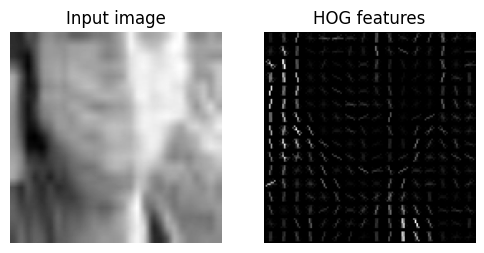

In [96]:
# visualize the HOG features
image = positive_images[0]
hog_features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2", visualize=True)

fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Input image')
axes[0].axis('off')
axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG features')
axes[1].axis('off')
plt.show()

In [97]:
# Directory containing the images and XML files
input = [r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\fcv\face']

# Crop size
crop_size = (64, 128)

# Directory to save the cropped positive images
positive_output_dir = r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\cropped'
Path(positive_output_dir).mkdir(parents=True, exist_ok=True)

# Directory to save the cropped negative images
negative_output_dir = r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\cropped'
Path(negative_output_dir).mkdir(parents=True, exist_ok=True)

# Iterate over each directory
for input_dir in input:
    # Iterate over each XML file in the directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".xml"):
            # Parse the XML file
            tree = ET.parse(os.path.join(input_dir, filename))
            root = tree.getroot()

            # Read the corresponding image
            img_filename = root.find('filename').text
            img = cv2.imread(os.path.join(input_dir, img_filename))

            # Create a mask of the same size as the image, filled with ones
            mask = np.ones(img.shape[:2], dtype=bool)

            # Iterate over each 'object' element in the XML file
            for i, obj in enumerate(root.iter('object')):
                # Get the bounding box coordinates
                bndbox = obj.find('bndbox')
                x1 = int(bndbox.find('xmin').text)
                y1 = int(bndbox.find('ymin').text)
                x2 = int(bndbox.find('xmax').text)
                y2 = int(bndbox.find('ymax').text)

                # Crop and resize the object from the image
                crop_img = img[y1:y2, x1:x2]
                crop_img = cv2.resize(crop_img, crop_size)

                # Save the cropped image based on the object type
                output_filename = f'{img_filename.split("_jpg")[0]}_crop_{i}.jpg'
                cv2.imwrite(os.path.join(positive_output_dir, output_filename), crop_img)

            # Generate negative samples
            for i in range(len(root.findall('object'))):
                while True:
                    # Choose a random location for the crop
                    y = np.random.randint(0, img.shape[0] - crop_size[1])
                    x = np.random.randint(0, img.shape[1] - crop_size[0])

                    # If the crop does not overlap with any object, save it and break the loop
                    if mask[y:y+crop_size[1], x:x+crop_size[0]].all():
                        crop_img = img[y:y+crop_size[1], x:x+crop_size[0]]
                        crop_img = cv2.resize(crop_img, crop_size)
                        cv2.imwrite(os.path.join(negative_output_dir, f'{img_filename.split("_jpg")[0]}_neg_crop_{i}.jpg'), crop_img)
                        break

IndexError: index 30 is out of bounds for axis 0 with size 30

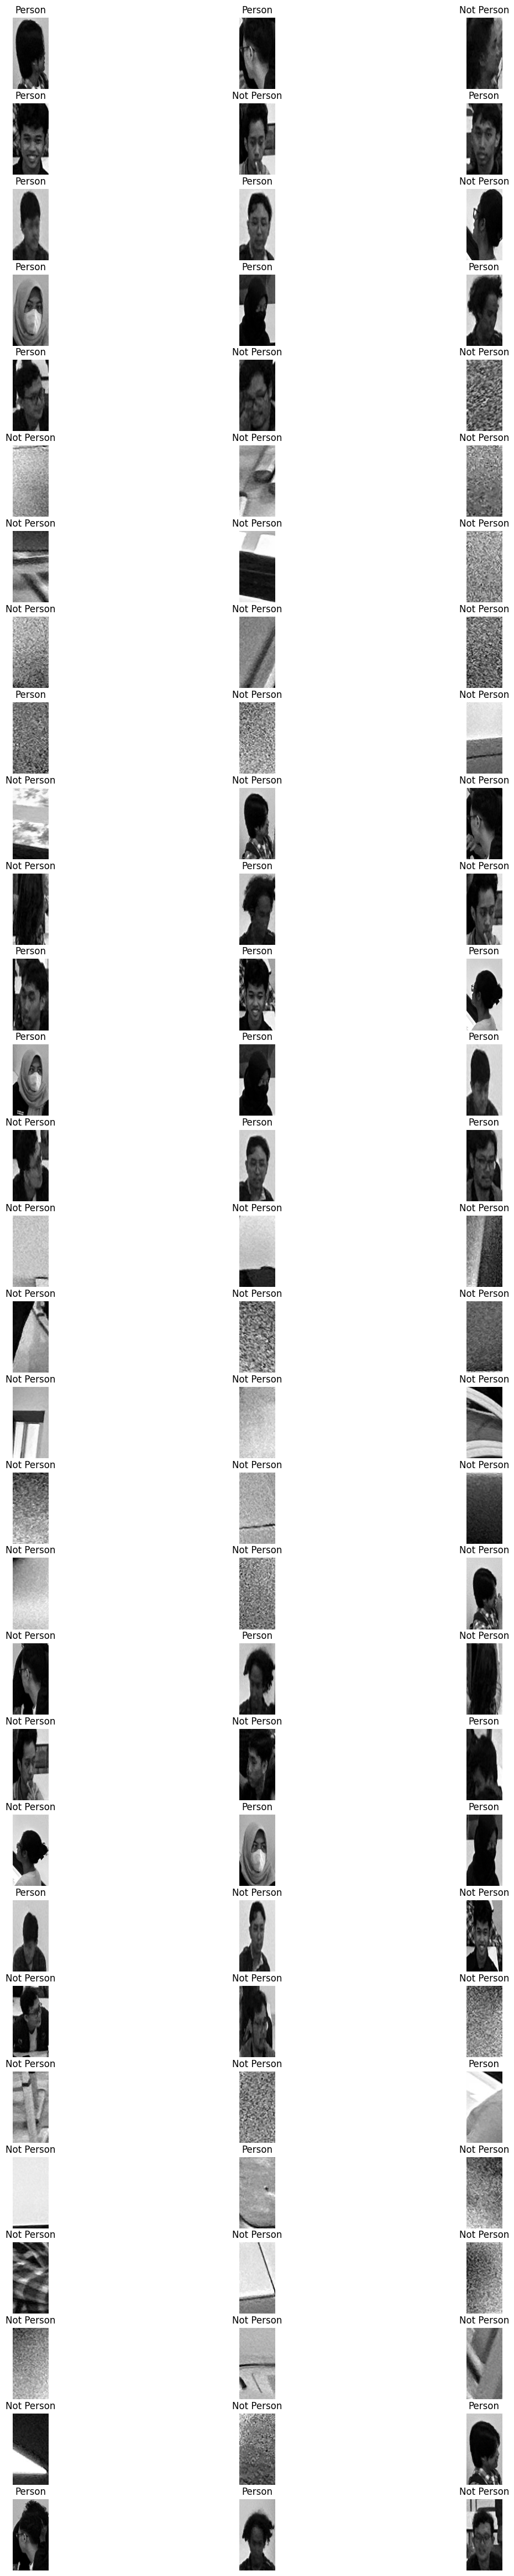

In [98]:
# load the testing images from 'test' directory
test_dir = r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\cropped'
test_images = []
for filename in os.listdir(test_dir):
    image = cv2.imread(os.path.join(test_dir, filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        test_images.append(image)

# Extract HOG features for the test images
test_features = extract_features(test_images)

# Scale the test features
test_features_scaled = scaler.transform(test_features)

# Predict the labels for the test set
test_pred = model.predict(test_features_scaled)

# Visualize the test images with the predicted labels
fig, axes = plt.subplots(30, 3, figsize=(15, 60))
for i, (image, pred) in enumerate(zip(test_images, test_pred)):
    axes[i // 3, i % 3].imshow(image, cmap='gray')
    axes[i // 3, i % 3].axis('off')
    axes[i // 3, i % 3].set_title('Person' if pred == 1 else 'Not Person')
plt.show()

ga 

In [ ]:
# load the testing images from 'test' directory
test_dir = r'C:\Users\WatsonNick\Downloads\People-Counter-master\People-Counter-master\Top View\INRIA Person detection dataset.v1i.voc\test'
test_images = []
for filename in os.listdir(test_dir):
    image = cv2.imread(os.path.join(test_dir, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    test_images.append(image)

# Extract HOG features for the test images
test_features = extract_features(test_images)

# Scale the test features
test_features_scaled = scaler.transform(test_features)

# Predict the labels for the test set
test_pred = model.predict(test_features_scaled)

# Calculate the number of rows and columns for subplots
num_images = len(test_images)
num_rows = (num_images + 2) // 3
num_cols = min(num_images, 3)

# Visualize the test images with the predicted labels
fig, axes = plt.subplots(num_rows, num_cols, figsize=(19, 6))
for i, (image, pred) in enumerate(zip(test_images, test_pred)):
    axes[i // num_cols, i % num_cols].imshow(image, cmap='gray')
    axes[i // num_cols, i % num_cols].axis('off')
    axes[i // num_cols, i % num_cols].set_title('Person' if pred == 1 else 'Not Person')
plt.show()

error: OpenCV(3.4.18) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
